In [1]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import collections
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize, OneHotEncoder
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
base_path = "/content/drive/MyDrive/EEG/"
columns = pd.read_csv(base_path + "columnLabels.csv").columns

In [6]:
columns

Index(['subject', 'trial', 'condition', 'sample', 'Fp1', 'AF7', 'AF3', 'F1',
       'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7',
       'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3',
       'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz',
       'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz',
       'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6',
       'P8', 'P10', 'PO8', 'PO4', 'O2', 'VEOa', 'VEOb', 'HEOL', 'HEOR', 'Nose',
       'TP10'],
      dtype='object')

In [7]:
demography = pd.read_csv(base_path + "demographic.csv")
subjects = demography['subject']
types = demography[' group']
subject_type = {subjects[i]:types[i] for i in range(len(subjects))}

In [8]:
def averaged_N_rows(a, n):
    assert a.shape[0] % n == 0
    b = a.reshape(a.shape[0] // n, n, a.shape[1])
    mean_vec = b.mean(axis=1)
    return mean_vec

In [9]:
def read_subject(data, subject_idx):
    trialCount = collections.Counter(data.trial)
    all_data = []
    labels = []
    scaler = MinMaxScaler()
    ohe = OneHotEncoder()
    for t in trialCount:
        if trialCount[t] != 9216:
            continue
        trial_data = data[data.trial == t]
        trial_data = averaged_N_rows(trial_data.drop(columns=["subject", "trial", "sample", "condition"]).values, 64)
#         cond = ohe.fit_transform(trial_data[:, 0].reshape(-1, 1)).toarray()
        trial_data = scaler.fit_transform(trial_data)
        # extract subject and condition, average on the rest
#         all_data.append(np.concatenate([cond, trial_data], axis=1))
        all_data.append(trial_data)
        labels.append(subject_type[subject_idx])
    return np.array(all_data), np.array(labels)

In [10]:
def read_all_subjects():
    all_labels = []
    all_subjects_data = []
    subjects = [path for path in os.listdir("../eeg_data/") if path.endswith(".csv")]
    for subject in tqdm(subjects):
        subject_idx = int(subject.split(".")[0])
        data = pd.read_csv(os.path.join("../eeg_data/", subject, subject), header=None, names=columns)
        data, labels = read_subject(data, subject_idx)
        all_subjects_data.append(data)
        all_labels.append(labels)
    return np.concatenate(all_subjects_data, axis=0), np.concatenate(all_labels)

### Run if data has not been processed yet

In [ ]:
all_subjects, all_labels = read_all_subjects()

FileNotFoundError: ignored

In [ ]:
all_subjects.shape

In [ ]:
np.save("data_extracted", all_subjects)
np.save("labels", all_labels)

### Directly load in processed data

In [11]:
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [13]:
all_subjects = np.load(base_path + "data_extracted.npy")
all_labels = np.load(base_path + "labels.npy")
labelsOHE = OneHotEncoder().fit_transform(all_labels.reshape(-1, 1)).toarray()

In [14]:
subjects = torch.Tensor(all_subjects)[:, None, :, :]
labels = torch.Tensor(labelsOHE)

In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_test, y_train, y_test = train_test_split(subjects, labels, test_size=0.25, random_state=42, stratify=labels)

train_dataset = TensorDataset(X_train, y_train) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size=32) # create your dataloader

test_dataset = TensorDataset(X_test, y_test) # create your datset
test_dataloader = DataLoader(test_dataset, batch_size=32) # create your dataloader

### Model Building

In [16]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input: 144x70x1, output: 71x34x16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3,3), stride=2)
        self.act1 = nn.LeakyReLU()
        # self.drop1 = nn.Dropout(0.3)

        # input: 71x34x16, output: 35x16x32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3), stride=2)
        self.act2 = nn.LeakyReLU()

        # input: 35x16x32, output:17x7x32
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2)
        self.act3 = nn.LeakyReLU()

        self.flat = nn.Flatten()

        self.fc5 = nn.Linear(3808, 512)
        self.act5 = nn.ReLU()
        # self.drop5 = nn.Dropout(0.5)

        self.fc6 = nn.Linear(512, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        # x = self.act4(self.conv4(x))
        x = self.flat(x)
        x = self.act5(self.fc5(x))
        # x = self.drop5(x)
        # input 512, output 10
        x = self.sigmoid(self.fc6(x))
        return x


model = CNNModel().to(device)
# Define the loss function and optimizer
criterion = nn.BCELoss()

adam_optimizer = optim.SGD(model.parameters(), lr=0.02)

# Print the model architecture
print(model)

CNNModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
  (act1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (act2): LeakyReLU(negative_slope=0.01)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (act3): LeakyReLU(negative_slope=0.01)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc5): Linear(in_features=3808, out_features=512, bias=True)
  (act5): ReLU()
  (fc6): Linear(in_features=512, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)


In [17]:
# Define training parameters
epochs = 100
val_accuracies = []
# Training loop

model = model.cuda()
for epoch in range(epochs):
    total_loss = 0

    for (batch_X, batch_y) in train_dataloader:
        # Zero the gradients
        adam_optimizer.zero_grad()
        # Forward pass
        outputs = model(batch_X.cuda())
        # Compute the loss
        loss = criterion(outputs, batch_y.cuda())
        # Backward pass
        loss.backward()
        # Update weights
        adam_optimizer.step()
        total_loss += loss.item()
    # Print average loss for the epoch
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader):.4f}")
    # Validation
    model.eval()
    with torch.no_grad():
      val_acc = []
      for (batch_X, batch_y) in test_dataloader:
        val_outputs = model(batch_X.cuda())
        val_loss = criterion(val_outputs, batch_y.cuda())

        # If y_val is one-hot encoded
        _, val_preds = torch.max(val_outputs, 1)
        _, yv = torch.max(batch_y, 1)
        # print(val_preds, yv)

        val_acc.append((val_preds == yv.cuda()).float().mean().item())
      val_accuracies.append(np.mean(val_acc))

    print(f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {np.mean(val_acc):.4f}")

Epoch 1, Loss: 0.6817
Validation Loss: 0.7488, Validation Accuracy: 0.5950
Epoch 2, Loss: 0.6745
Validation Loss: 0.7588, Validation Accuracy: 0.5950
Epoch 3, Loss: 0.6744
Validation Loss: 0.7589, Validation Accuracy: 0.5950
Epoch 4, Loss: 0.6744
Validation Loss: 0.7590, Validation Accuracy: 0.5950
Epoch 5, Loss: 0.6743
Validation Loss: 0.7591, Validation Accuracy: 0.5950
Epoch 6, Loss: 0.6743
Validation Loss: 0.7592, Validation Accuracy: 0.5950
Epoch 7, Loss: 0.6743
Validation Loss: 0.7594, Validation Accuracy: 0.5950
Epoch 8, Loss: 0.6742
Validation Loss: 0.7595, Validation Accuracy: 0.5950
Epoch 9, Loss: 0.6742
Validation Loss: 0.7596, Validation Accuracy: 0.5950
Epoch 10, Loss: 0.6741
Validation Loss: 0.7597, Validation Accuracy: 0.5950
Epoch 11, Loss: 0.6741
Validation Loss: 0.7598, Validation Accuracy: 0.5950
Epoch 12, Loss: 0.6740
Validation Loss: 0.7600, Validation Accuracy: 0.5950
Epoch 13, Loss: 0.6740
Validation Loss: 0.7601, Validation Accuracy: 0.5950
Epoch 14, Loss: 0.673

In [18]:
preds = torch.argmax(model(X_test.cuda()), axis=1)
y_test_labels = torch.argmax(y_test.cuda(), axis=1)

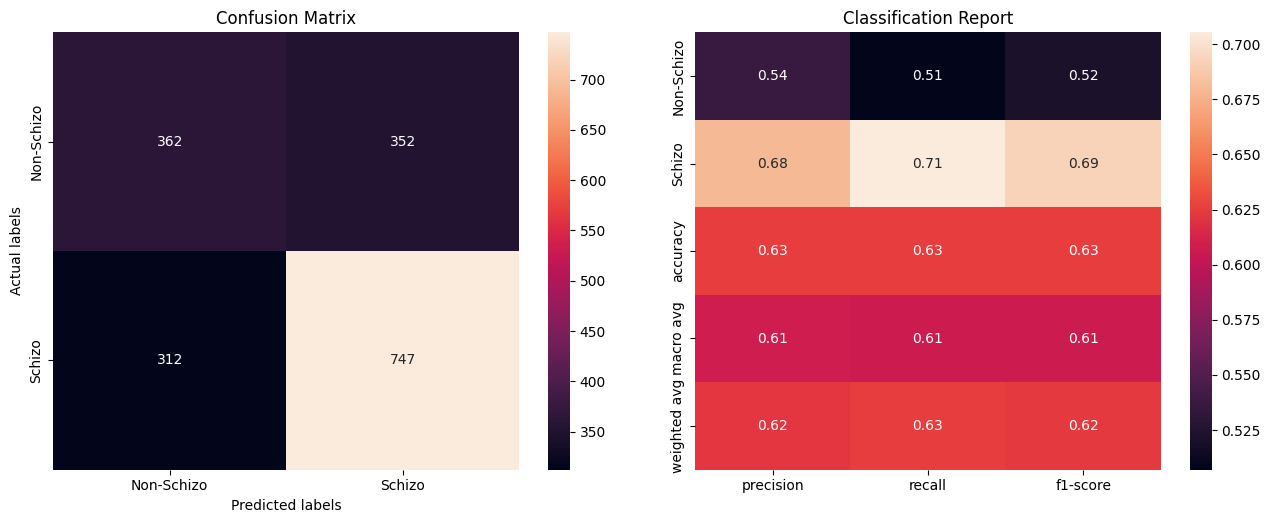

In [22]:
PlotPerformance(y_test_labels.cpu(), preds.cpu(), ['Non-Schizo', 'Schizo']);

### HCNN

In [ ]:
class HCNNSimple:
  def __init__(self, networks, train_images, train_labels, val_images, val_labels):
    self.train_images = train_images
    self.train_labels = train_labels
    self.val_images = val_images
    self.val_labels = val_labels
    self.num_train_samples = 0
    self.num_classes = 2
    self.epochs = 30
    self.category_weights = [0] * self.num_classes
    self.gamma = 0.25
    self.networks = networks
    for label in train_labels:
      self.num_train_samples += 1
      self.category_weights[label] += 1
    for i in range(self.num_classes):
      self.category_weights[i] /= self.num_train_samples

    self.weights = []
    for i in range(self.num_train_samples):
      self.weights.append(1 / self.num_train_samples)

  def weighted_CE(self, y_true, y_pred):
    y_true = tf.reshape(y_true, (-1,))
    sample_weight = [self.category_weights[y_s] for y_s in y_true]
    cce = tf.keras.losses.SparseCategoricalCrossentropy()
    return cce(y_true, y_pred, sample_weight=sample_weight)

  def total_loss(self, y_true, y_pred):
    triplet = tfa.losses.triplet.TripletSemiHardLoss()
    return self.weighted_CE(y_true, y_pred) + self.gamma * triplet(y_true, y_pred)

  def train(self, ind):
    # TODO: train subnetworks, update weights
    names = ['res', 'mobile', 'ef']
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.02)
    # optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    models = []
    hist = []
    metrics = ['accuracy']
    for i in range(len(self.networks)):
      network = self.networks[i]
      model_name = f"/content/drive/MyDrive/EEG/{names[i]}_{ind}.h5"
      # TODO: use max accuracy instead of min loss
      mcp_save = tf.keras.callbacks.ModelCheckpoint(model_name, save_best_only=True, monitor='val_accuracy', mode='max', save_weights_only=False)
      network.compile(optimizer=optimizer, loss=self.total_loss, metrics=metrics, run_eagerly=True)
      history = network.fit(self.train_images, self.train_labels,
                            epochs=self.epochs, batch_size=16, validation_data=(self.val_images, self.val_labels), callbacks=[mcp_save])
      self.update_weights(network, self.train_images, self.train_labels)
      models.append(network)
      hist.append(history)
    return models, hist

  def update_weights(self, model, imgs, labels):
    y_true = []
    for label in labels:
      y_true.append(label)
    y_true = np.array(y_true)
    y_pred = np.argmax(model.predict(imgs), axis=1)

    epsilon = 0
    for i in range(len(y_pred)):
      if y_pred[i] != y_true[i]:
        epsilon += self.weights[i]
    alpha = 0.5 * np.log((1 - epsilon) / epsilon)

    for i in range(len(y_pred)):
      if y_pred[i] != y_true[i]:
        self.weights[i] *= np.exp(alpha)
      else:
        self.weights[i] *= np.exp(-alpha)

    self.category_weights = [0, 0, 0]
    for i in range(len(y_true)):
      self.category_weights[y_true[i]] += self.weights[i]

In [ ]:
models = []
perf = []
mn = tf.keras.applications.MobileNet(
  input_shape=(144,70,1),
  include_top=False,
  weights=None,
)
en = tf.keras.applications.EfficientNetB0(
  input_shape=(144,70,1),
  include_top=False,
  weights=None,
)
resnet50 = tf.keras.applications.resnet50.ResNet50(
  input_shape=(144,70,1),
  include_top=False,
  weights=None,
)

model1 = tf.keras.models.Sequential([
    mn,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    # tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(2, activation="sigmoid")
])

model2 = tf.keras.models.Sequential([
    en,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    # tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(2, activation="sigmoid")
])

model3 = tf.keras.models.Sequential([
    resnet50,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    # tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(2, activation="sigmoid")
])

h = HCNNSimple([model3, model1, model2], np.squeeze(X_train.numpy()), np.argmax(y_train.numpy(), axis=1), np.squeeze(X_test.numpy()), np.argmax(y_test.numpy(), axis=1))
model, p = h.train(1)
models.append(model)
perf.append(p)

In [ ]:
ef_best = tf.keras.models.load_model(f"/content/drive/MyDrive/EEG/efficientnet.h5", compile=False)
mn_best = tf.keras.models.load_model(f"/content/drive/MyDrive/EEG/mobilenet.h5", compile=False)
rn_best = tf.keras.models.load_model(f"/content/drive/MyDrive/EEG/resnet.h5", compile=False)

In [ ]:
class HCNNpred:
  def __init__(self, models, hm):
    self.models = models
    self.hm = hm
  def predict(self, img):
    preds = []
    for i in range(len(self.models)):
      model = self.models[i]
      # img_exp = tf.expand_dims(img / 255.0, 0)
      pred = model.predict(img, verbose=0)
      high_prob = np.max(pred, axis=1)
      preds.append(np.argmax(pred, axis=1)[0])
      # print(Counter(preds).most_common(1))
      # if high_prob >= self.hm or i == len(self.models) - 1:
      if high_prob >= self.hm or i == len(self.models) - 1:
        # return np.argmax(pred, axis=1)[0]
        return pred

In [ ]:
t_imgs = torch.permute(X_test, (0, 2, 3, 1))

In [ ]:
predictor = HCNNpred([rn_best, ef_best, mn_best], 0.97)
preds = []
for img in t_imgs.numpy():
  pred = predictor.predict(np.expand_dims(img, axis=0))
  preds.append(np.argmax(pred, axis=1))

In [ ]:
np.count_nonzero(np.squeeze(preds)-np.argmax(y_test.numpy(), axis=-1)) / len(preds)

0.3570219966159052

In [ ]:
mn_best.predict(np.expand_dims(t_imgs.numpy()[0], axis=0))

1/1 [==============================] - 0s 248ms/step


array([[0.99994886, 0.999984  ]], dtype=float32)

In [20]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
def PlotPerformance(test_labels, test_pred, labels):
  cm=confusion_matrix(test_labels,test_pred)
  cr=classification_report(test_labels, test_pred)
  class_report=classification_report(test_labels, test_pred, target_names=labels, output_dict=True)
  # print(class_report)
  fig, (ax, ax2)= plt.subplots(1, 2, figsize=(13, 5))
  plt.tight_layout(pad=1.2)
  # plt.tight_layout()
  sns.heatmap(cm, annot=True,ax=ax, fmt='d')
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('Actual labels')
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  # plt.show()
  # plt.savefig("/content/drive/MyDrive/Pap ML Project For Paper 2 (Shared Drive)/sample.jpg")
  # ax2= plt.subplot()
  sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T,
              annot=True,ax=ax2)
  ax2.set_title('Classification Report')
  plt.show()
  return class_report

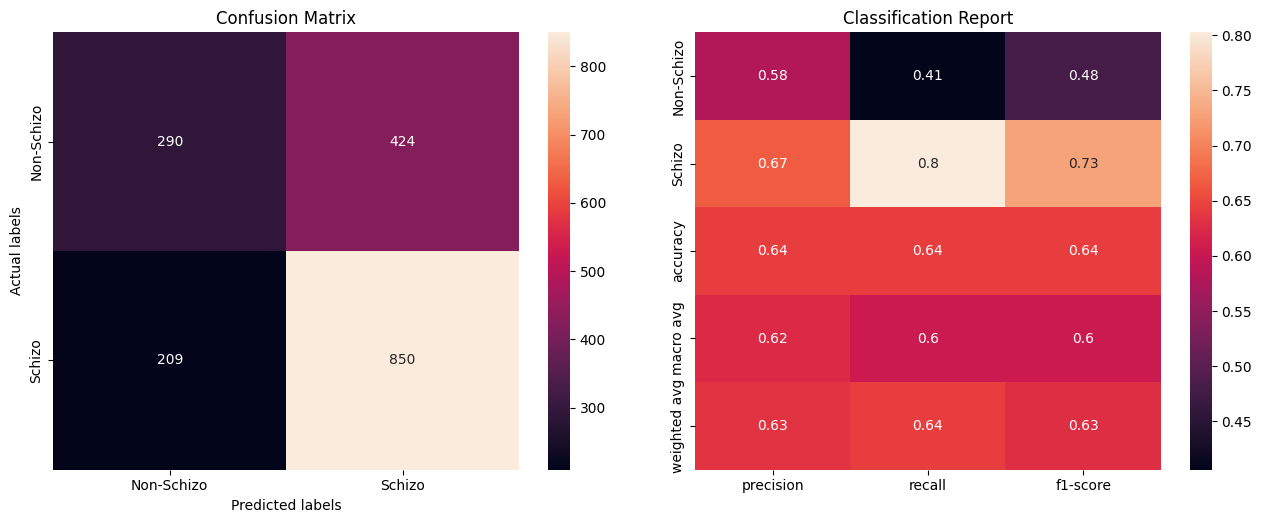

In [ ]:
PlotPerformance(np.argmax(y_test.numpy(),axis=-1), np.squeeze(preds), ["Non-Schizo", "Schizo"]);

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [ ]:
train = X_train.squeeze().numpy().reshape(-1, 144*70)
test = X_test.squeeze().numpy().reshape(-1, 144*70)

trainL = np.argmax(y_train.numpy(), axis=1)
testL = np.argmax(y_test.numpy(), axis=1)

In [ ]:
svc_best = None
svc_acc = 0
for n in range(10, 200, 10):
  tr = X_train.squeeze().numpy().reshape(-1, 144*70)
  t = X_test.squeeze().numpy().reshape(-1, 144*70)

  trainL = np.argmax(y_train.numpy(), axis=1)
  testL = np.argmax(y_test.numpy(), axis=1)
  pca = PCA(n_components=n)
  train = pca.fit_transform(tr)
  test = pca.transform(t)
  svc = SVC().fit(tr, trainL)
  score = svc.score(t, testL)
  if score > svc_acc:
    svc_acc = score
    svc_best = (svc, tr, t)
print(svc_acc)

0.6548223350253807


In [ ]:
svc_pred = svc_best[0].predict(svc_best[2])

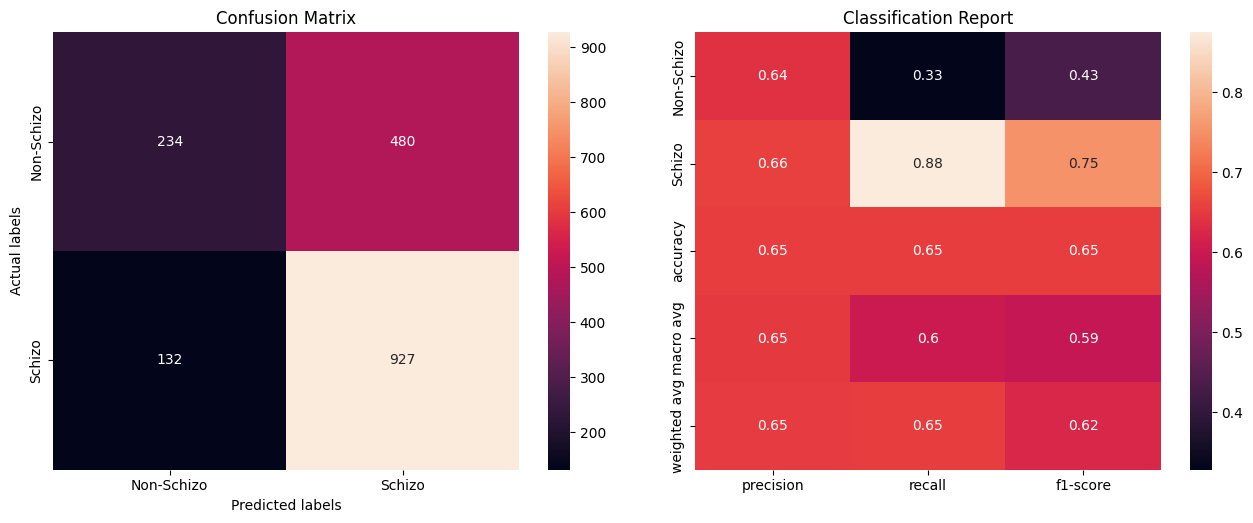

In [ ]:
PlotPerformance(testL, svc_pred, ['Non-Schizo', 'Schizo']);

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
best_model = None
best_param = {'dimension':0, 'alpha':0}
best_acc = 0
for dim in range(1000, 5000, 500):
  pca = PCA(n_components=dim, random_state=42)
  tr = pca.fit_transform(train)
  t = pca.transform(test)

  for alpha in np.arange(0.1, 1.5, 0.1):
    clf = MLPClassifier(alpha=alpha, max_iter=1000, random_state=42, hidden_layer_sizes=(32, 32, 16)).fit(tr, trainL)
    # clf = KNeighborsClassifier(n_neighbors=alpha).fit(tr, tr_multi_labels)
    score = clf.score(t, testL)
    if score > best_acc:
      best_model = clf
      best_param = {'dimension': dim, 'alpha': alpha}
      best_acc = score

In [ ]:
best_acc, best_param

(0.6734348561759729, {'dimension': 4500, 'alpha': 0.1})

In [ ]:
pca = PCA(n_components=4500, random_state=42).fit(train)

In [ ]:
t = pca.transform(test)
mlp_preds = best_model.predict(t)

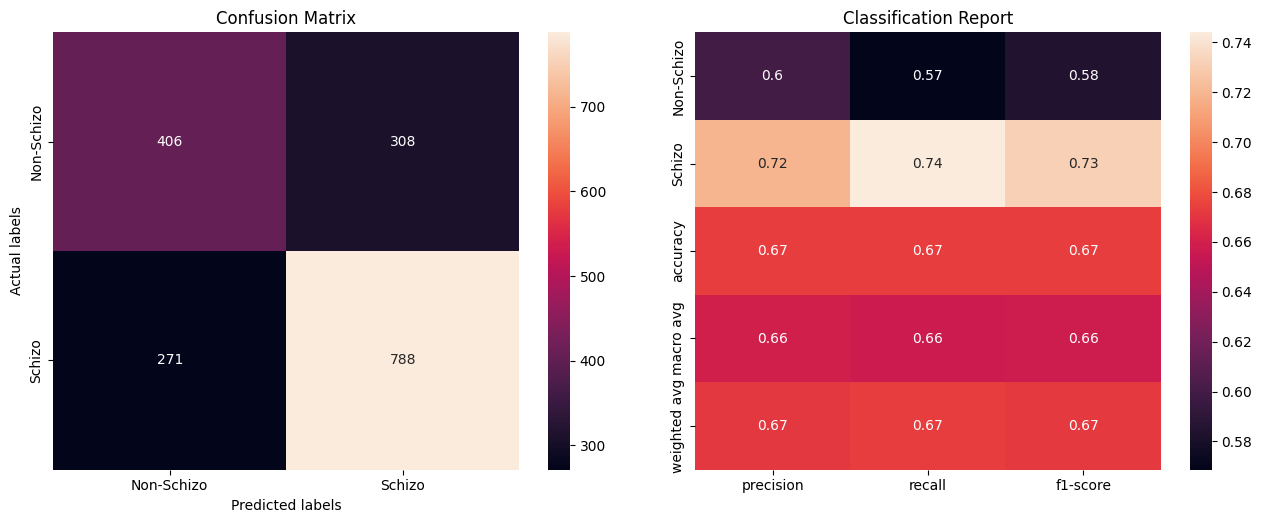

In [ ]:
PlotPerformance(testL, mlp_preds, ['Non-Schizo', 'Schizo']);